In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
# exp_folder = 'D:\\Leo\\0503'
exp_folder = 'C:\\Users\\llinc\\GitHub\\retina_personal\\0229'
# exp_folder = 'D:\\Leo\\0503'
annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_HMM_UR_DL_G4.5_5min_Q100_6.5mW.mat')

In [3]:
channelnumber =48-1
#os.chdir('C:\\Users\\llinc\\OneDrive\\桌面\\新增資料夾')

In [4]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

(150, 160)

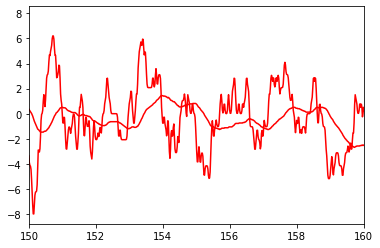

In [6]:
x = np.abs(np.squeeze(annots['bin_pos']))
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
dt = 1./60
T=np.squeeze(annots['diode_BT'])
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'r-')
plt.xlim(150,160)

In [7]:
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)
t_cor

0.7665499454037397

In [8]:
realr, edges = np.histogram(annots['reconstruct_spikes'][0][channelnumber], np.append(0,T))
realr[np.where(realr >= 2)] = 2
np.unique(realr)

array([0, 1, 2], dtype=int64)

In [9]:
(len(realr)-(np.shape(np.where(realr==0))[1]))/len(realr) #non-zero state percentage

0.049822261719617865

In [10]:
deltaT =0.6
r = x+v*deltaT
rstate=np.zeros(len(r))
model = 3
if model == 0: #'randomly not fire' + 'real distributed' + 'poisson process'
    counter = 0
    for n in np.arange(1, max(realr)+1):
        edge = np.sort(r)[counter]
        counter += round((np.shape(np.where(realr==n))[1])/(len(r)-(np.shape(np.where(realr==0))[1]))*len(r))
        rstate[r>=edge] = np.random.poisson(n)
    randomly_not_fire = np.append(np.ones(len(r)-(np.shape(np.where(realr==0))[1])), np.zeros(np.shape(np.where(realr==0))[1]))
    np.random.shuffle(randomly_not_fire)
    rstate = rstate*randomly_not_fire
    rstate = rstate.astype(int)
elif model == 1: #'real distributed' + 'poisson process'
    counter = 0
    for n in np.unique(realr):
        edge = np.sort(r)[counter]
        counter += (np.shape(np.where(realr==n))[1])
        rstate[r>=edge] = np.random.poisson(n)
elif model == 2: #'fake distributed' 
    edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
    rstate=np.zeros(len(r))
    for i in range(4):
        rstate[r>=edges[i]] = i
elif model == 3: #'burst distributed' + 'randomly not fire' 
    counter = 0
    burst_distr = np.array([0.95, 0.6, 0.4]);
    for n in np.arange(1,3):
        edge = np.sort(r)[int(counter)]
        counter += int(len(r)*burst_distr[n]+0.5)
        rstate[r>=edge] = n
    randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
    np.random.shuffle(randomly_not_fire)
    rstate = rstate*randomly_not_fire
    rstate = rstate.astype(int)
else:  #'real spike'
    rstate = realr

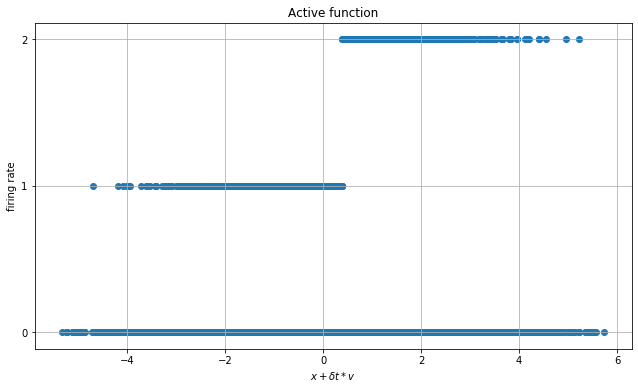

In [11]:
plt.scatter(r, rstate)
plt.title('Active function')
plt.gcf().set_size_inches(10.7, 6)
# plt.xticks(edges, [r'$min$', r'$\mu+\sigma$',r'$\mu+2*\sigma$',r'$\mu+3*\sigma$'])
plt.yticks(np.unique(rstate))
plt.ylabel('firing rate')
plt.xlabel(r'$x+\delta t*v$')
plt.grid(True)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


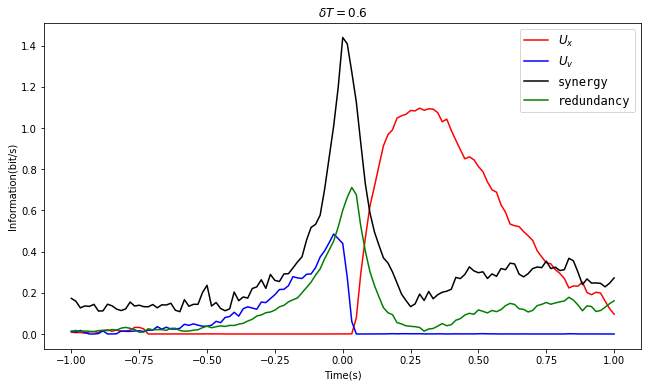

In [12]:
#rstate = np.random.poisson(rstate)
xstate = EqualState(x, 6)
vstate = EqualState(v, 6)
#calculate information
window = [-1,1] # second
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
#plot PI
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title(r'$\delta T=$'+str(deltaT))
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

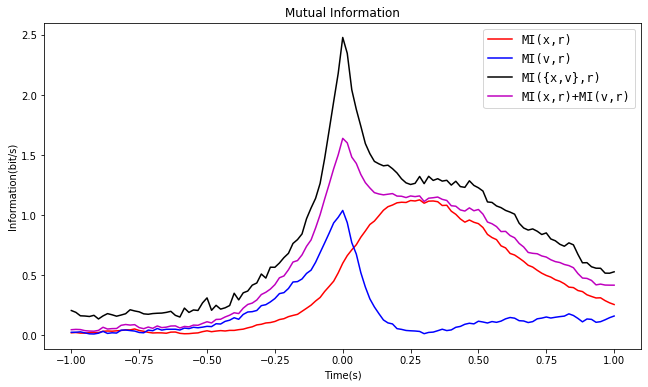

In [13]:
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.savefig(str(deltaT)+'_fake_spike_MI.tiff')

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


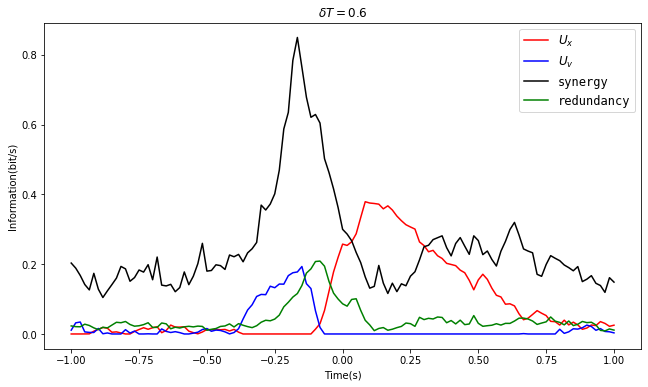

In [14]:
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(realr, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
#plot PI
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')
plt.title(r'$\delta T=$'+str(deltaT))
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.gcf().set_size_inches(10.7, 6)
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.show()

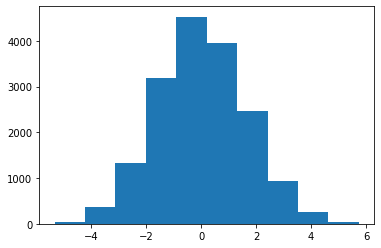

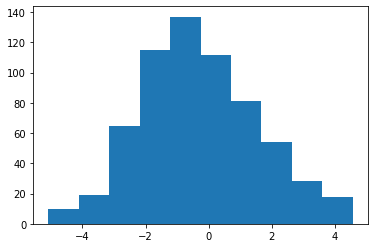

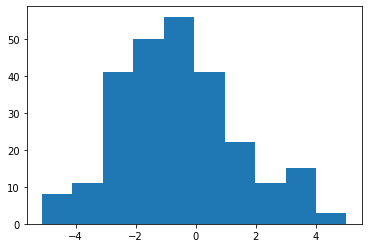

In [15]:
for n in np.unique(realr):
    fig, ax = plt.subplots()
    hst = ax.hist(r[np.where(realr == n)])